The aim of this script is to plot the Figures of the LW_down analysis

In [16]:
import intake
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import glob
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker



def setup_matplotlib(font_size=15):
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size, labelsize=font_size)
    plt.rc('xtick', labelsize=font_size)
    plt.rc('ytick', labelsize=font_size)
    plt.rc('legend', fontsize=font_size)
setup_matplotlib()
SIZE = 15

In [17]:
LW_down_clouds = xr.open_dataset('./../data/processed_data/LW_down_clouds_2020_tot.nc')['LWdown_diffuse']
LW_down_clouds = LW_down_clouds.sel(distance=slice(-25000,25000))
windspeed = xr.open_dataset('./../data/windspeed_eurec4a.nc')['wind_speed']
windspeed_avg = windspeed.sel(range = 1000, method = 'nearest').mean(dim = 'time')
half_time_cloud = 300

In [18]:
#We define the two sets of data, i.e., the two sets of clouds: shallow and deep with a mask
mask_shallow = ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) > 100) & \
       ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) < 700) & \
       ((LW_down_clouds.cloud_length) > 40) & \
       ((LW_down_clouds.cloud_bottom) < 1500)
LW_down_clouds_shallow = LW_down_clouds[mask_shallow]


mask_deep = ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) > 700) & \
       ((LW_down_clouds.cloud_top - LW_down_clouds.cloud_bottom) < 2500) & \
       ((LW_down_clouds.cloud_length) > 40) & \
       ((LW_down_clouds.cloud_bottom) < 1500)
LW_down_clouds_deep = LW_down_clouds[mask_deep]

## Plotting functions profiles of $LW\downarrow$ and RE

Here are defined some functions that process some data and prepare somes plots that are being used later for plotting the figures

In [4]:
def find_saturation_point(binned_array, threshold):
    """
    Find the saturation point in a binned array where the difference between consecutive bins is below a threshold.
    This saturation point is the clear-sky radiation. It is used to find the Radiative effect of envelopes (as we need to remove the clear-sky component)
    
    Inputs:
    - binned_array: xarray.DataArray, the input binned array with decreasing values. In this case LW_down
    - threshold: float, the threshold below which the difference between consecutive bins indicates saturation.
    
    Outpus:
    - saturation_bin: the bin index where the saturation occurs. -> the length of the envelope
    - saturation_value: the value at the saturation bin. -> the clear-sky RE (once the day-to-day variability has been removed)
    """
    
    # Calculate the differences between consecutive bins
    differences = np.abs(np.diff(binned_array))
    
    # Find the indices where the difference is below the threshold
    saturation_indices = np.where(differences < threshold)[0]
    
    if len(saturation_indices) == 0:
        raise ValueError("No saturation point found within the given threshold")
    
    # Check if at least two consecutive bins have differences below the threshold
    #If at least two points are below the threshold, then we define this point as the saturation index
    consecutive_count = 1
    for i in range(1, len(saturation_indices)):
        if saturation_indices[i] == saturation_indices[i-1] + 1:
            consecutive_count += 1
            if consecutive_count >= 2:
                # Get the saturation value from the binned array
                saturation_index = saturation_indices[i - 1]
                saturation_value = binned_array[saturation_index].item()
                return saturation_index, saturation_value
        else:
            consecutive_count = 1
    
    raise ValueError("No saturation point found within the given threshold")

In [5]:
def binning_envelope_edge_mean(RE_mean, threshold, save_path=None, title=None):
    """
    This function plots the binned RE (up- and downwind average). From the averaged binned signal, we use the find_saturation_point() function,
    to find the clear-sky RE

    Inputs:
    - RE_mean: the mean RE of all clouds
    - threshold: the threshold used to define the ssaturation point (as in function find_saturation_point()).

    Outputs:
    - Plot of the averaged binned RE
    - Saturation value, i.e., clear-sky RE
    - Saturation index, i.e., extent of envelope

    """

    #We first separate the up- and downwind signals
    data_up = RE_mean.sel(distance=slice(0, 30000))
    data_up['distance'] = data_up['distance'] - half_time_cloud*windspeed_avg # this adjustment is need to put the distance 0 at the border of the cloud
    data_down = RE_mean.sel(distance=slice(-30000, 0))
    data_down['distance'] = data_down['distance'] + half_time_cloud*windspeed_avg

    #definition of bins for distances
    bin_edges = range(0, int(data_up.distance.max()) + 1000, 1000)  # Bins of 1000 meters
    
    # Bin the values by distances: both for up and down
    binned_RE_mean_up = data_up.groupby_bins('distance', bins=bin_edges).mean(dim='distance')
    binned_RE_std_up = data_up.groupby_bins('distance', bins=bin_edges).std(dim='distance')
    binned_RE_count_up = data_up.groupby_bins('distance', bins=bin_edges).count(dim='distance')
    
    data_down = data_down[::-1]  # Invert the axis to have also positive distances
    data_down['distance'] = -1 * data_down['distance']
    binned_RE_mean_down = data_down.groupby_bins('distance', bins=bin_edges).mean(dim='distance')
    binned_RE_std_down = data_down.groupby_bins('distance', bins=bin_edges).std(dim='distance')
    binned_RE_count_down = data_down.groupby_bins('distance', bins=bin_edges).count(dim='distance')
    
    # Compute the mean of the upwind and downwind data:
    combined_mean = (binned_RE_mean_up + binned_RE_mean_down) / 2
    
    #Computation of standard deviations used as errors
    combined_std = (binned_RE_std_up + binned_RE_std_down) / 2
    
    # Get saturation index and value with the previous function
    saturation_index, saturation_value = find_saturation_point(combined_mean, threshold)
    
    #we define the clear-sky as the mean value of combined_mean as long as combined_mean is above the saturation_value
    clear_sky_RE = np.mean(combined_mean[combined_mean < saturation_value]).item()
    print('The saturation is reached at ', np.array(bin_edges)[saturation_index + 1], ' m, and at a value of ', round(clear_sky_RE, 3), ' $W.m^{-2}$ which corresponds to the clear-sky radiation')
    
    bin_mids = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

    # Plot of the binned averaged RE
    fig = plt.figure(figsize=(15, 5))
    G = gridspec.GridSpec(1, 1, hspace=1)
    ax1 = plt.subplot(G[0, 0])
    ax1.errorbar(bin_mids, combined_mean, yerr=combined_std, fmt='o', markersize=4, linestyle='-', label='Combined mean RE')
    ax1.axvspan(0, np.array(bin_edges)[saturation_index + 1], color='gray', alpha=0.4, label='Envelope extent')
    ax1.axhline(y=saturation_value, label='Saturation value', color='orange')
    ax1.set_xlim(0, 23000)
    ax1.set_xlabel(r'Distance from cloud / ${\rm m}$')
    ax1.set_ylabel(r'$LW_{\Delta \, cloud}$ / ${\rm W\, m}^{-2}$')
    ax1.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=False, ncol=3)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    return np.array(bin_edges)[saturation_index + 1], saturation_value

In [6]:
def cumulative_RE_plot_combined(RE_mean, saturation_value, save_path=None, title=None):
    """
    This function plots the normalised cumulative mean RE of the sky as a function of distance. It also shows the effective extent
    of the envelope defined as when 90% of the total RE effect is reached

    Iputs:
    - RE_mean: mean RE of the envelope
    - saturation value, that value of the clear-sky radiation

    Outputs:
    - plot of normalised cumulative RE
    - effective extent of the envelope

    """
    
    # Compute net radiative effect: RE - RE_clear_sky for up and down
    RE_net_up = RE_mean.sel(distance=slice(0, 30000))
    RE_net_up['distance'] = RE_net_up['distance'] - half_time_cloud*windspeed_avg
    RE_net_up = RE_net_up.where(RE_net_up >= saturation_value, drop=True)
    RE_net_up = RE_net_up - saturation_value

    #same for down
    RE_net_down = RE_mean.sel(distance=slice(-30000, 0))
    RE_net_down['distance'] = RE_net_down['distance'] + half_time_cloud*windspeed_avg
    RE_net_down['distance'] = -1 * RE_net_down['distance']
    RE_net_down = RE_net_down[::-1]  # Invert the axis to have positive distances
    RE_net_down = RE_net_down.where(RE_net_down >= saturation_value, drop=True)
    RE_net_down = RE_net_down - saturation_value

    
    # Combine RE_net_up and RE_net_down
    RE_net_combined = xr.concat([RE_net_up, RE_net_down], dim='distance')
    
    # Compute the total RE net effect, as sum of the combined
    RE_net_tot = RE_net_combined.sum(dim='distance')
    
    # Determine envelope border
    envelope_border = RE_net_combined['distance'].max().item()
    
    # Prepare bins and compute normalized RE
    bin_edges = np.arange(0, envelope_border, 1000)
    sum_by_bins = RE_net_combined.groupby_bins('distance', bins=bin_edges).sum()
    std_by_bins = RE_net_combined.groupby_bins('distance', bins=bin_edges).std() / 4#RE_net_combined.groupby_bins('distance', bins=bin_edges).count()
    RE_norm = (sum_by_bins / RE_net_tot)
    
    # Cumulative sum of the normalised RE
    RE_norm_sum = RE_norm.cumsum()
    
    # Get index at which 90% of the total RE net effect is reached to plot the effective extent of the envelope
    index = np.argmax(RE_norm_sum.values >= 0.9)
    effective_distance = sum_by_bins['distance_bins'].values[index].mid
    
    # Plotting
    fig = plt.figure(figsize=(15, 5))
    #plot_title = title if title else "Cumulative normalised RE contribution for each bin of distances from cloud"
    #fig.suptitle(plot_title, y=0.98)
    G = gridspec.GridSpec(1, 1, hspace=0.5)
    
    ax = plt.subplot(G[0, 0])
    distance_bin_centers = [interval.mid for interval in RE_norm_sum['distance_bins'].values]
    ax.errorbar(distance_bin_centers, RE_norm_sum.values, yerr=std_by_bins.values, fmt='o', linestyle='--', capsize=4, capthick=1, elinewidth=1, markersize=5, color='#1f77b4', label = 'cumulative net RE')
    distance_bin_centers.insert(0, 0.0) #to plot the gray bar from 0 and not from 500, But then need to add +2 instead of +1 in the next line
    ax.fill_between(distance_bin_centers[0:index + 2], 0, 1.1, color='gray', alpha=0.4, label = 'effective envelope extent')
    ax.set_xlabel(r'Distance from cloud / ${\rm m}$')
    ax.set_ylabel('Normalised radiative effect')
    ax.set_ylim(0, 1.05)
    ax.set_xlim(0, 23000)
    ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=False, ncol=2)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    return effective_distance

In [7]:
def cumulative_RE_plot(RE_mean, saturation_value, save_path=None, title=None):
    """
    This function does the same as the previous one cumulative_RE_plot_combined() but separates the up and downwind contributions
    
    For more detailed informations, refer to the explanation of the previous function
    """
    
    #we first compute the net radiaitve effect: RE - RE_clear_sky for up and down
    #we also restrict to only the envelop, as otherwise we'll get negative values as the clear sky still slightly decreases after the saturation point
    RE_net_up = RE_mean.sel(distance=slice(0,30000))
    RE_net_up['distance'] = RE_net_up['distance'] - half_time_cloud*windspeed_avg.item()
    RE_net_up = RE_net_up.where(RE_net_up >= saturation_value, drop=True)
    RE_net_up = RE_net_up - saturation_value
    RE_net_up_tot = RE_net_up.sum(dim='distance')
    
    
    RE_net_down = RE_mean.sel(distance=slice(-30000,0))
    RE_net_down['distance'] = RE_net_down['distance'] + half_time_cloud*windspeed_avg.item()
    RE_net_down['distance'] = -1*RE_net_down['distance']
    RE_net_down = RE_net_down[::-1]       #invert the axis to have also positive distances
    RE_net_down = RE_net_down.where(RE_net_down >= saturation_value, drop=True)
    RE_net_down = RE_net_down - saturation_value
    RE_net_down_tot = RE_net_down.sum(dim='distance')

    
    
    envelope_border_up = RE_net_up['distance'].max().item()
    envelope_border_down = RE_net_down['distance'].max().item()
    
    #prepare the bins and compute the normalised RE
    bin_edges_up = np.arange(0, envelope_border_up, 1000)
    bin_edges_down = np.arange(0, envelope_border_down, 1000)

    sum_by_bins_up = RE_net_up.groupby_bins('distance', bins=bin_edges_up).sum()
    std_by_bins_up = RE_net_up.groupby_bins('distance', bins=bin_edges_up).std()/2#/RE_net_up.groupby_bins('distance', bins=bin_edges_up).count()
    RE_norm_up = (sum_by_bins_up/RE_net_up_tot)

    sum_by_bins_down = RE_net_down.groupby_bins('distance', bins=bin_edges_down).sum()
    std_by_bins_down = RE_net_down.groupby_bins('distance', bins=bin_edges_down).std()/2#RE_net_down.groupby_bins('distance', bins=bin_edges_down).count()
    RE_norm_down = (sum_by_bins_down/RE_net_down_tot)
    
    #cumulative sum:
    RE_norm_down_sum = RE_norm_down.cumsum()
    RE_norm_up_sum = RE_norm_up.cumsum()

    #get index at which 90% of the total RE net effect is reached to plot th effective extent of the envelope:
    index_down = np.argmax(RE_norm_down_sum.values >= 0.9)
    index_up = np.argmax(RE_norm_up_sum.values >= 0.9)

    effective_distance_down = sum_by_bins_down['distance_bins'].values[index_down].mid
    effective_distance_up = sum_by_bins_up['distance_bins'].values[index_up].mid
    
    
    #plot
    fig = plt.figure(figsize=(15, 5))
    #plot_title = title if title else "Cumulative normalised RE contribution for each bin of distances from cloud"
    #fig.suptitle(plot_title, y=.98)
    G = gridspec.GridSpec(1, 2, hspace=.5)


    ax1 = plt.subplot(G[0, 0])
    distance_bin_centers = [interval.mid for interval in RE_norm_down_sum['distance_bins'].values]
    ax1.errorbar(distance_bin_centers, RE_norm_down_sum.values, yerr=std_by_bins_down.values, fmt='o', linestyle='--', capsize=4, capthick=1, elinewidth=1,markersize=5, color='#1f77b4')
    distance_bin_centers.insert(0, 0.0) #to plot the gray bar from 0 and not from 500, But then need to add +2 instead of +1 in the next line
    ax1.fill_between(distance_bin_centers[0:index_down+2], 0, 1.1, color='gray', alpha=0.4)
    ax1.set_xlabel(r'Distance from cloud / ${\rm m}$')
    ax1.set_ylabel('Normalised radiative effect')
    ax1.set_title('Downwind')
    ax1.set_xlim(0, 23000)
    ax1.set_ylim(0,1.05)
    #for x, y in zip(distance_bin_centers, RE_norm_sum_before.values):
    #    ax1.text(x, y + 0.05, f'{y:.2f}', ha='center', va='bottom')


    ax2 = plt.subplot(G[0, 1])
    distance_bin_centers = [interval.mid for interval in RE_norm_up_sum['distance_bins'].values]
    ax2.errorbar(distance_bin_centers, RE_norm_up_sum.values, yerr=std_by_bins_up.values, fmt='o', linestyle='--', capsize=4, capthick=1, elinewidth=1,markersize=5, color='#1f77b4', label = 'cumulative net RE')
    distance_bin_centers.insert(0, 0.0) #to plot the gray bar from 0 and not from 500, But then need to add +2 instead of +1 in the next line
    ax2.fill_between(distance_bin_centers[0:index_up+2], 0, 1.1, color='gray', alpha=0.4, label='effective envelope extent')
    ax2.set_xlabel(r'Distance from cloud / ${\rm m}$')
    ax2.set_ylabel('Normalised radiative effect')
    ax2.set_title('Upwind')
    ax2.set_xlim(0, 23000)
    ax2.set_ylim(0,1.05)
    ax2.legend(loc="lower center", bbox_to_anchor=(-0.1, -0.3), fancybox=True, shadow=False, ncol=2)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    return effective_distance_down, effective_distance_up

## Plotting

In [8]:
def plots_LW_down(LW_down, type_of_clouds):
    """
    function that plots the main profiles of the downward longwave analysis, it can be used for shallow and deep clouds
    """

    #PLOT 1: COMPOSITE OF LW_DOWN AS FUNCTION OF DISTANCE
    # Plotting the data
    LW_down_clouds.mean(dim='cloud').plot(label='Downward longwave radiation', figsize=(15, 5))
    
    # Adding vertical lines for cloud borders
    plt.axvline(x=-windspeed_avg.item() * half_time_cloud, color='orange', label='clouds boundaries')
    plt.axvline(x=windspeed_avg.item() * half_time_cloud, color='orange')
    
    # Setting the y-label
    plt.ylabel(r'Downward longwave radiation / ${\rm W \, m}^{-2}$')
    plt.xlabel('Distance from cloud boundaries / m')
    # Setting the x-ticks
    xticks_positions = np.array([-20000 - windspeed_avg.item() * half_time_cloud, 
                                 -10000 - windspeed_avg.item() * half_time_cloud,
                                 -windspeed_avg.item() * half_time_cloud,
                                 windspeed_avg.item() * half_time_cloud,
                                 10000 + windspeed_avg.item() * half_time_cloud,
                                 20000 + windspeed_avg.item() * half_time_cloud])
    
    xticks_labels = [-20000, -10000, 0, 0, 10000, 20000]
    
    plt.xticks(xticks_positions, xticks_labels)
    
    # Calculating midpoints between the major x-ticks for minor ticks, excluding the midpoint between the zeros
    minor_xticks_positions = [
        (xticks_positions[i] + xticks_positions[i+1]) / 2
        for i in range(len(xticks_positions) - 1)
        if not (xticks_labels[i] == 0 and xticks_labels[i+1] == 0)
    ]
    
    # Adding minor ticks on x-axis at the selected midpoints
    ax = plt.gca()
    ax.set_xticks(minor_xticks_positions, minor=True)
    
    # Adding half ticks on y-axis
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Automatically adds minor ticks between major ticks

    # Removing top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Detaching left and bottom spines
    ax.spines['left'].set_position(('outward', 20))
    ax.spines['bottom'].set_position(('outward', 1))
    
    # Enabling minor ticks on both axes
    ax.tick_params(which='minor', length=4, color='black')

    # Showing the plot with legend
    plt.legend()
    plt.savefig(f'../Figures/LW/LW_Down_cloud_composite_{type_of_clouds}.png', bbox_inches='tight')


    
    #we compute the Radiaitve effect of the envelope:
    #first remove the day-to-day variability (to put all the clouds on the same base)
    min_LW = LW_down.min(dim='distance', skipna =True) 
    RE = LW_down - min_LW 
    #compute the mean radiaitve effect for all clouds
    RE_mean = RE.mean(dim='cloud')

    
    #PLOT 2: BINNED AVERAGED (UP- AND DOWNWIND) LW_SUBTRACTED TO FIND CLEAR-SKY RADIATION AND ENVELOPE EXTENT
    fig_path = f'../Figures/LW/Binned_saturation_{type_of_clouds}.png'
    envelope_border, saturation_value = binning_envelope_edge_mean(RE_mean, 0.05, save_path=fig_path,
                             title=f'Binned decay of RE away from the cloud for {type_of_clouds} clouds (regardless the direction)')



    
    #PLOT 3:CUMULATIVE AVERAGED (UP- AND DOWNWIND) RE, TO FIND EFFECTIVE ENVELOPE EXTENT
    fig_path = f'../Figures/LW/Cum_RE_combined_{type_of_clouds}.png'

    effective_distance = cumulative_RE_plot_combined(RE_mean, saturation_value, save_path=fig_path)


    

    #PLOT 4: SAME AS THE PREVIOUS PLOT BUT SEPARATING THE UP- AND DOWNWIND CONTRIBUTIONS
    fig_path = f'../Figures/LW/Cum_RE_up_down_{type_of_clouds}.png'
    envelope_border_down, envelope_border_up = cumulative_RE_plot(RE_mean, saturation_value, save_path=fig_path)

    return RE_mean, saturation_value, envelope_border

The saturation is reached at  13000  m, and at a value of  6.078  $W.m^{-2}$ which corresponds to the clear-sky radiation


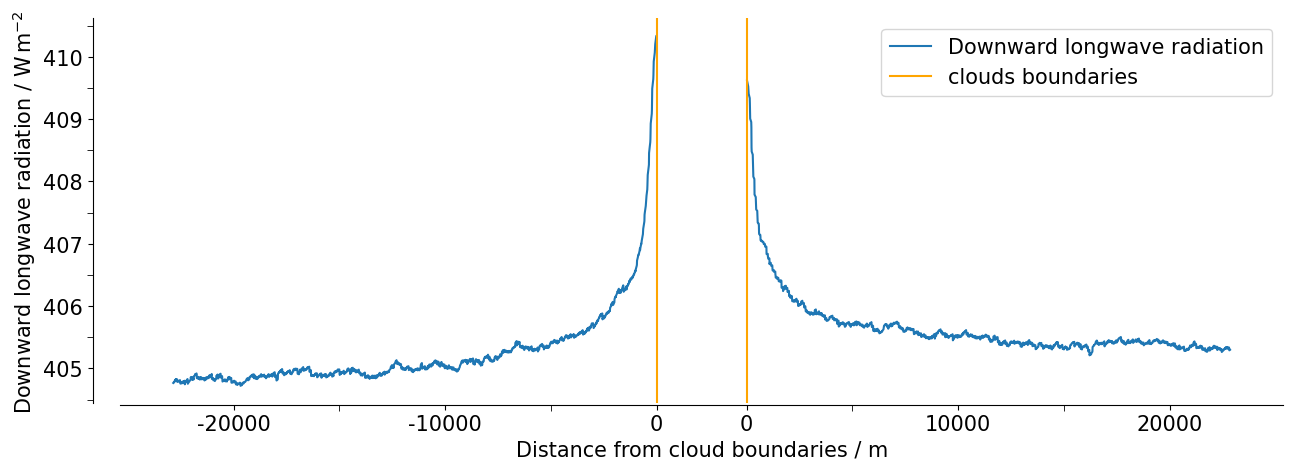

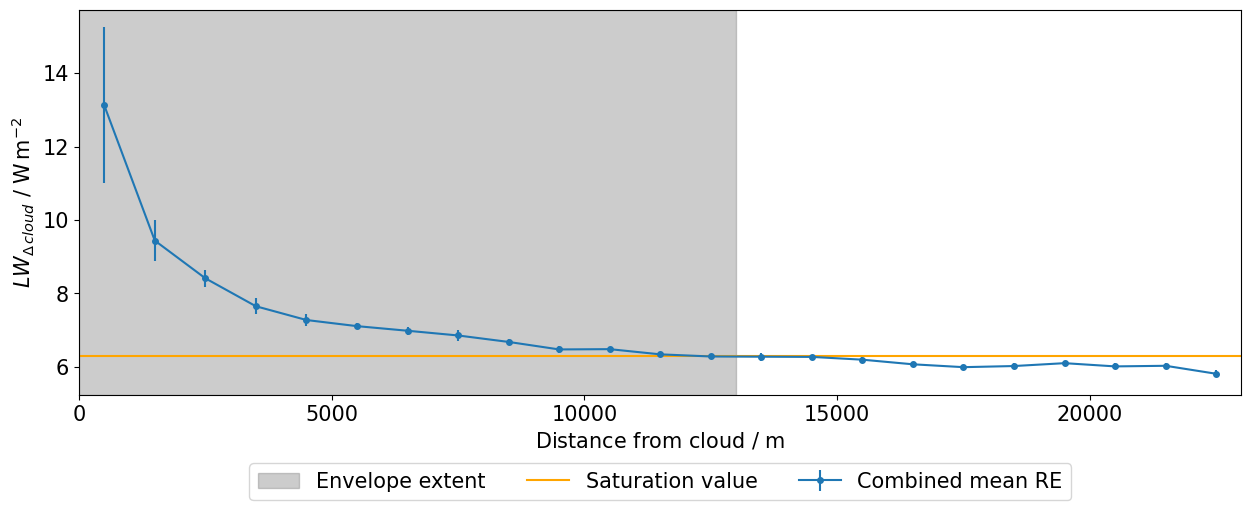

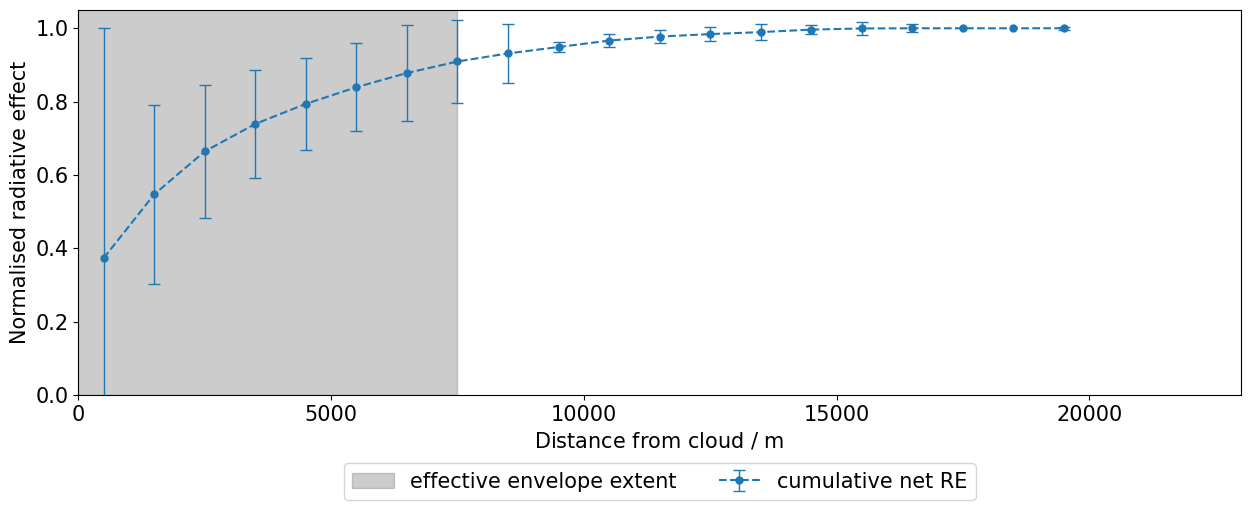

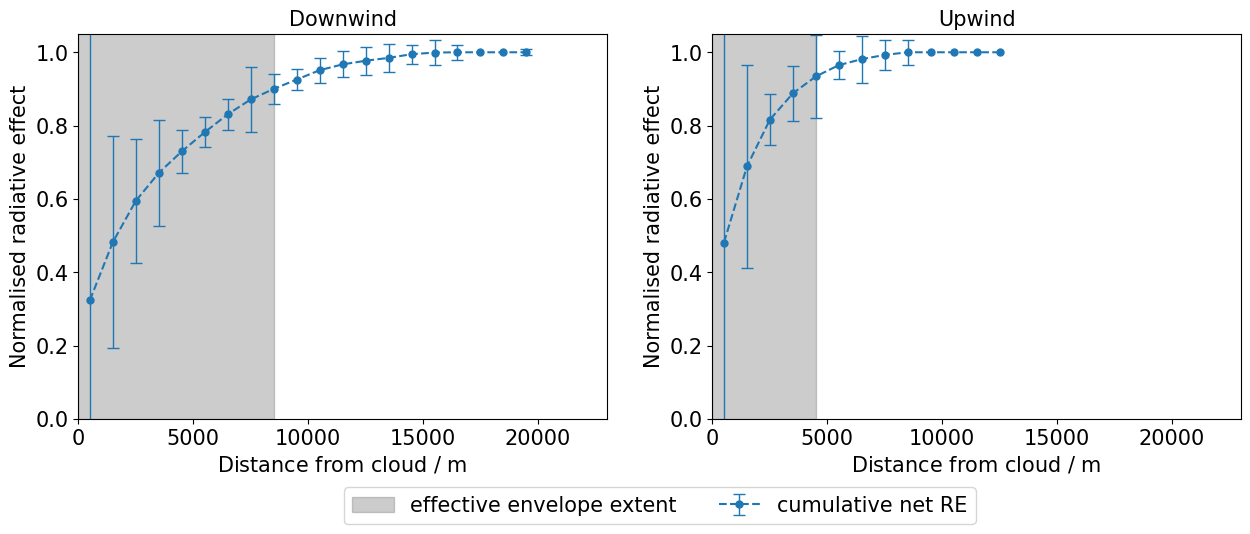

In [9]:
RE_mean_deep, saturation_value_deep, envelope_border_deep = plots_LW_down(LW_down_clouds_deep, 'deep')

The saturation is reached at  14000  m, and at a value of  5.833  $W.m^{-2}$ which corresponds to the clear-sky radiation


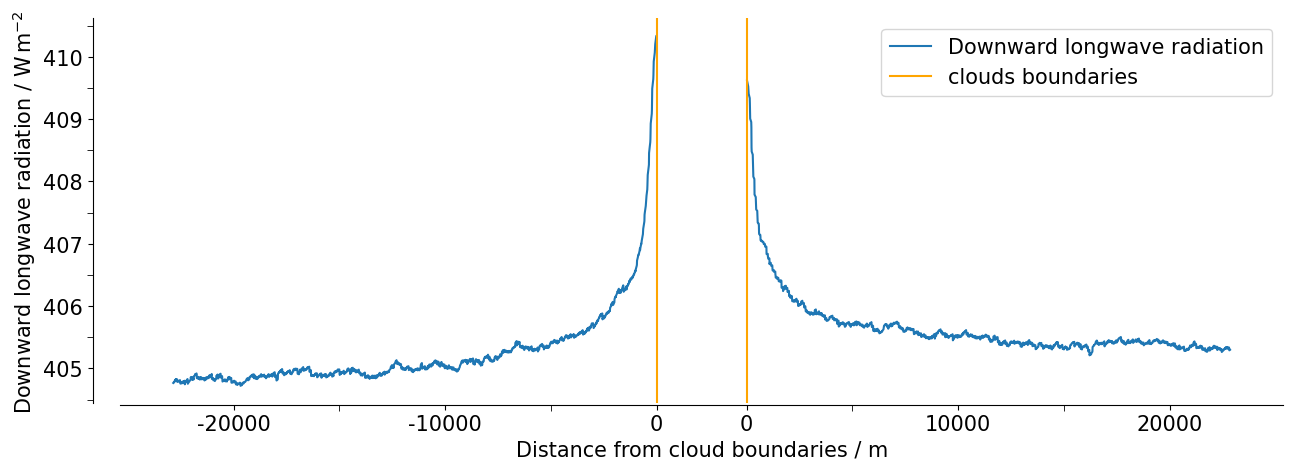

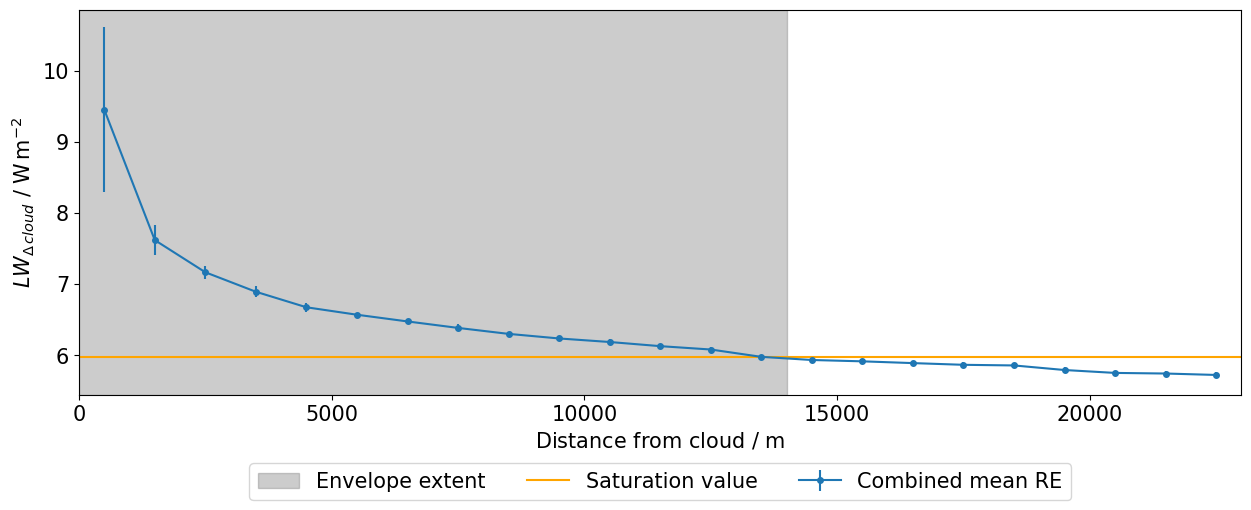

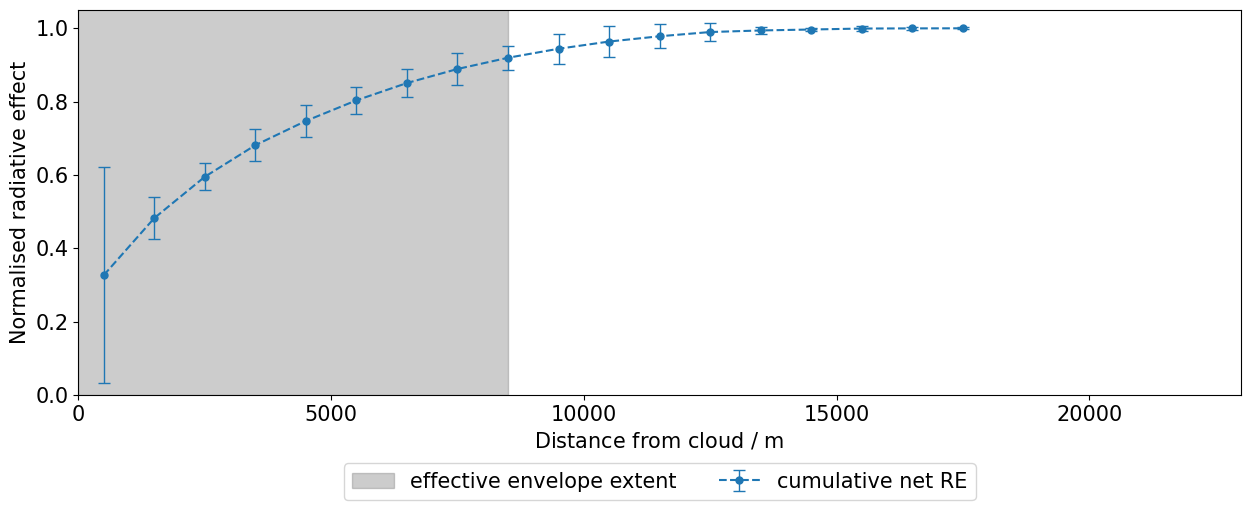

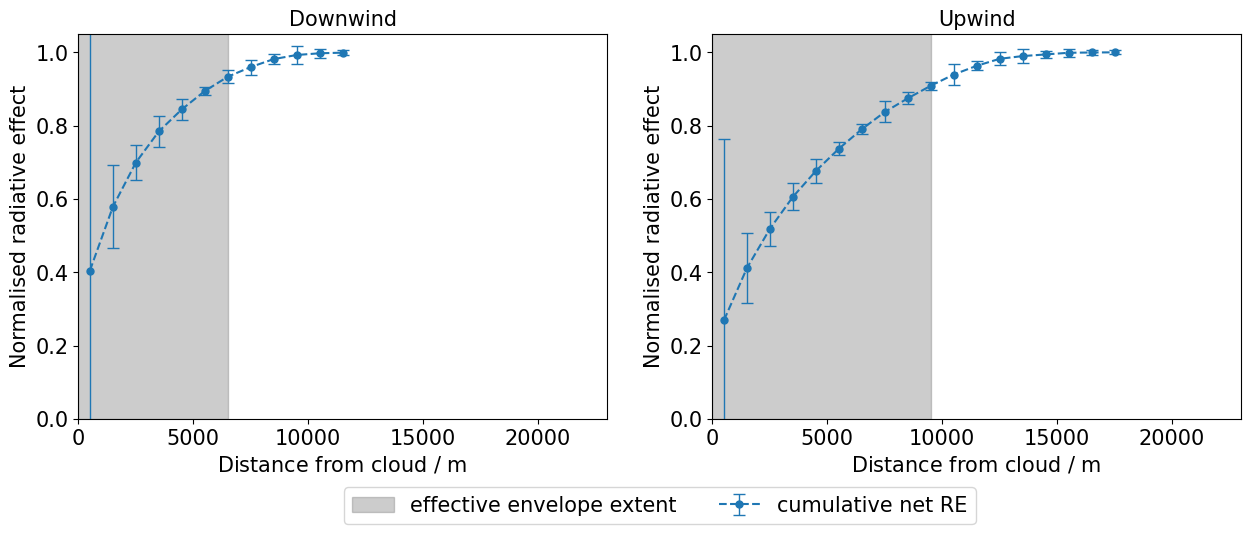

In [10]:
RE_mean_shallow, saturation_value_shallow, envelope_border_shallow = plots_LW_down(LW_down_clouds_shallow, 'shallow')

## Box plots plotting functions

In [11]:
def box_plot_tot_mean(RE_mean, saturation_value, envelope_border, save_path=None):
    """
    This function plots a box-plot of the total mean RE of the envelope.

    Inputs:
    - the mean total RE 
    - the saturation value, i.e., the clear-sky RE (that is removed to compute the RE of the envelope
    - the envelope border, to only take into account the border of the clouds

    Outputs:
    - the box-plot of the mean RE of the envelope along-side its mean and its error
    """

    #Computing the RE of the envelope, and restricting to the envelope, computation of the mean and of the standard deviation
    RE_net = RE_mean - saturation_value
    combined_data = RE_net.sel(distance = slice(- envelope_border - half_time_cloud*windspeed_avg, envelope_border + half_time_cloud*windspeed_avg))
    combined_data = combined_data.dropna(dim='distance')
    mean_tot = np.mean(combined_data)
    std_tot = np.std(combined_data)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(4, 5))
    axs.boxplot(combined_data)
    axs.set_xticklabels('')
    axs.set_ylabel(r'total RE of the envelope / ${\rm W \, m}^{-2}$')
    axs.text(0.6, 0.4, f'Mean: {mean_tot:.2f} \n'+'$Std_{err}:$' +f'{std_tot/len(combined_data):.2e}',
             transform=axs.transAxes, fontsize=SIZE, verticalalignment='top')
    axs.plot(1,mean_tot, 'o', color='orange')
    # Remove top and right spines
    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [12]:
def box_plot_up_down(RE_mean, saturation_value, envelope_border, save_path=None, title=None):
    """
    This function does as the previous one (box_plot_tot_mean()) but separates the up- and downwind contributions.
    Refer to the previous function to understand the inputs and outputs
    """
    
    #define the two sets of data, up- and downwind. COmpute their RE_net 
    RE_net_up = RE_mean - saturation_value
    RE_net_up = RE_net_up.sel(distance=slice(half_time_cloud*windspeed_avg,envelope_border+half_time_cloud*windspeed_avg))


    RE_net_down = RE_mean - saturation_value
    RE_net_down = RE_net_down.sel(distance=slice(-envelope_border-half_time_cloud*windspeed_avg,-half_time_cloud*windspeed_avg))
    RE_net_down = RE_net_down[::-1]       #invert the axis to have also positive distances
    RE_net_down['distance'] = -1*RE_net_down['distance']


    #remove the nan and get the means and std for each side of the cloud
    RE_net_up = RE_net_up.dropna(dim='distance')
    mean_up = np.mean(RE_net_up)
    std_up = np.std(RE_net_up)

    RE_net_down = RE_net_down.dropna(dim='distance')
    mean_down = np.mean(RE_net_down)
    std_down = np.std(RE_net_down)

    #create a single datframe for both to simplify the plotting
    combined_data = [np.array(RE_net_down), np.array(RE_net_up)]
    
    
    #box-plot
    fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

    axs.boxplot(combined_data)
    axs.set_xticks([1, 2])
    axs.set_xticklabels(['Downwind', 'Upwind'])
    axs.set_ylabel(r'total RE of the envelope / ${\rm W\, m}^{-2}$')

    axs.spines['top'].set_visible(False)
    axs.spines['right'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.text(0.3, 0.4, f'Mean: {mean_down:.2f}\n'+'$Std_{err}:$' +f'{std_down/len(combined_data[0]):.2e}',
             transform=axs.transAxes, fontsize=SIZE, verticalalignment='top')
    axs.text(0.8, 0.4, f'Mean: {mean_up:.2f} \n'+'$Std_{err}:$' +f'{std_up/len(combined_data[1]):.2e}',
             transform=axs.transAxes, fontsize=SIZE, verticalalignment='top')
    axs.plot([1, 2], [mean_down, mean_up], 'o', color='orange')


    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    plt.show()

## Box plots

In [13]:
def plots_LW_down_box(LW_down, RE_mean, saturation_value, envelope_border, type_of_clouds):
    """
    function that plots the box-plots of the downward longwave analysis, it can be used for shallow and deep clouds
    
    """

    #BOX-PLOT 1: COMPUTATION OF THE TOTAL MEAN RE OF THE ENVELOPE
    fig_path = f'../Figures/LW/Box_plot_{type_of_clouds}.png'

    box_plot_tot_mean(RE_mean, saturation_value, envelope_border, save_path=fig_path)


    #BOX-PLOT 2: COMPUTATION OF THE MEAN RE OF THE ENVELOPE BOTH UP- AND DOWNWIND
    fig_path = f'../Figures/LW/Box_plot_up_down_{type_of_clouds}.png'
    box_plot_up_down(RE_mean, saturation_value, envelope_border, save_path=fig_path)

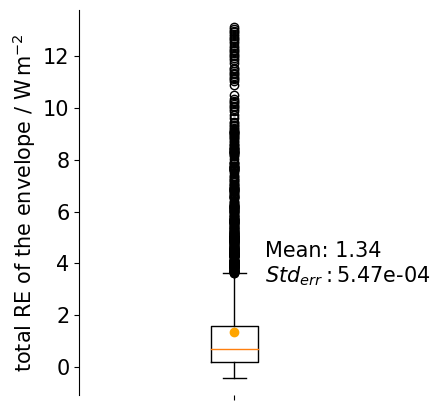

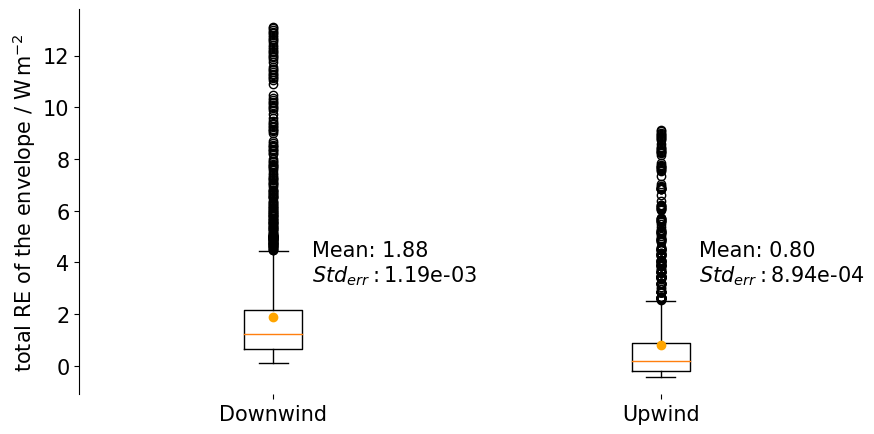

In [14]:
plots_LW_down_box(LW_down_clouds_deep, RE_mean_deep, saturation_value_deep, envelope_border_deep, 'deep')

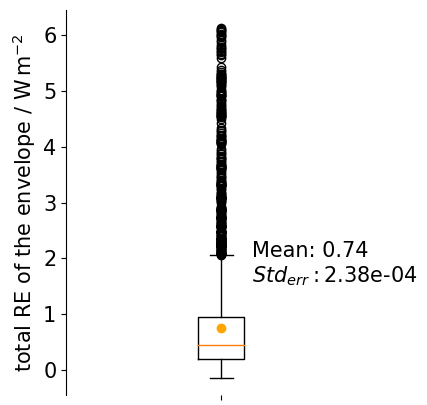

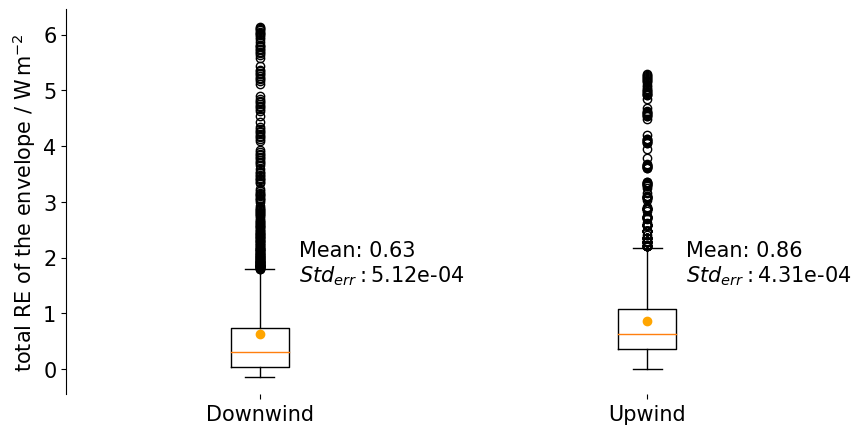

In [15]:
plots_LW_down_box(LW_down_clouds_shallow, RE_mean_shallow, saturation_value_shallow, envelope_border_shallow, 'shallow')